## Get the best runs

In [72]:
import neptune
from misc import save_json
import pandas as pd
import numpy as np
import os
from utils_neptune import start_neptune_run
from paretoset import paretoset
import matplotlib.pyplot as plt
import seaborn as sns


NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [103]:
def pareto_reduction(df, sense_list=None, current_set=None, desired_num=None, objective_cols=None):
    if desired_num is None:
        desired_num = np.floor(0.2*df.shape[0])
    if objective_cols is None:
        objective_cols = df.columns

    if df.shape[0] < desired_num*1.5:
        return df

    mask = paretoset(df[objective_cols], sense=sense_list)
    current_set = pd.concat([current_set, df[mask]])
    if current_set.shape[0] < desired_num:
        return pareto_reduction(df[~mask], sense_list, current_set, desired_num, objective_cols)
    else:
        return current_set

In [104]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1

    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    
    return df_out

In [105]:
encoder_kind = 'AE'
project = neptune.init_project(
    project='revivemed/RCC',
    mode="read-only",
    api_token=NEPTUNE_API_TOKEN
)

runs_table_df = project.fetch_runs_table(tag=['v3.1'],state='inactive').to_pandas()

#drop the failed runs
runs_table_df = runs_table_df[~runs_table_df['sys/failed']].copy()

#filter by encoder_kind
runs_table_df = runs_table_df[runs_table_df['pretrain/kwargs/encoder_kind'] == encoder_kind].copy()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/


Fetching table...: 0 [00:00, ?/s]

In [106]:
top_runs_table_df = project.fetch_runs_table(tag=['top'],state='inactive').to_pandas()
top_run_ids = top_runs_table_df['sys/id'].values

In [129]:
cols = ['sys/id']
obj_cols = [col for col in runs_table_df.columns if 'objectives/OBJ' in col]
obj_cols = [col for col in obj_cols if '(v3)' in col]
cols.extend(obj_cols)
df = runs_table_df[cols].copy()
df.set_index('sys/id', inplace=True)
df.columns = [col.split('/')[-1] for col in df.columns]
obj_cols = [col.split('/')[-1] for col in obj_cols]
print(obj_cols)
print('df shape:', df.shape)

['OBJ Adv StudyID (v3)', 'OBJ Gender (v3)', 'OBJ Pediatric (v3)', 'OBJ Recon (v3)']
df shape: (826, 4)


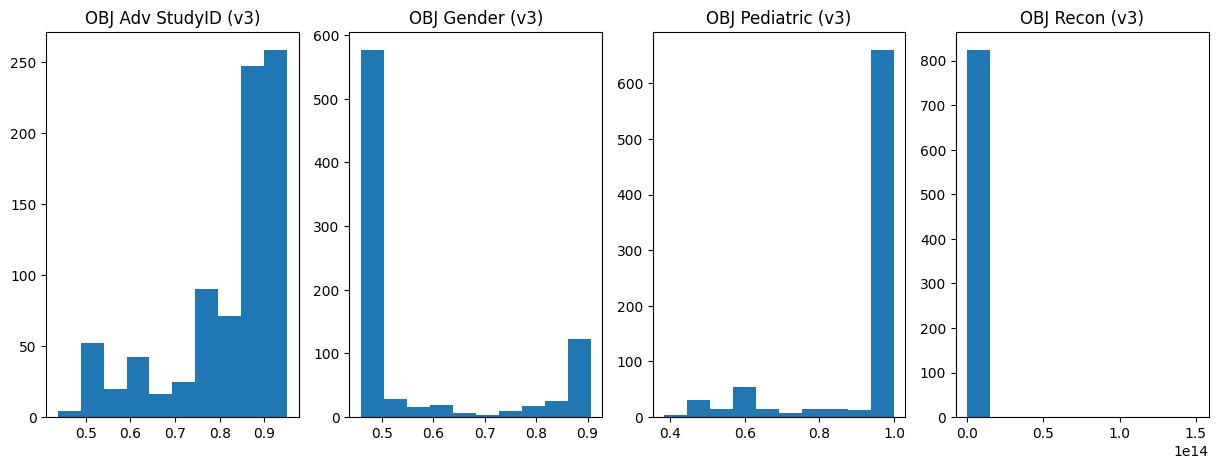

In [130]:
fig, axs = plt.subplots(1, len(df.columns), figsize=(15, 5))

for i, col in enumerate(df.columns):
    axs[i].hist(df[col])
    axs[i].set_title(col)

plt.show()


In [131]:
col = 'OBJ Recon (v3)'
new_col = 'log10 OBJ Recon (v3)'
df[new_col] = np.log10(df[col])
# remove the old column
df.drop(col, axis=1, inplace=True)
objective_cols = [col for col in df.columns if 'OBJ' in col]

In [132]:
objective_cols = [col for col in df.columns if 'OBJ' in col]

In [110]:
# col = 'OBJ Recon (v3)'
# df = remove_outliers(df, col)
# print('df shape:', df.shape)   

# for col in obj_cols:
#     df = remove_outliers(df, col)
# print('df shape:', df.shape)    

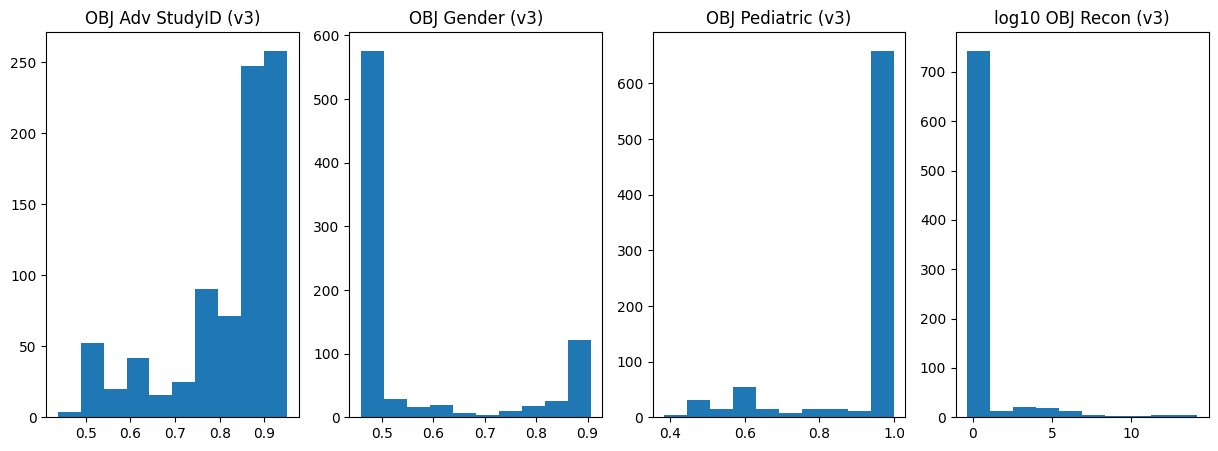

In [133]:
fig, axs = plt.subplots(1, len(df.columns), figsize=(15, 5))

for i, col in enumerate(df.columns):
    axs[i].hist(df[col])
    axs[i].set_title(col)

plt.show()

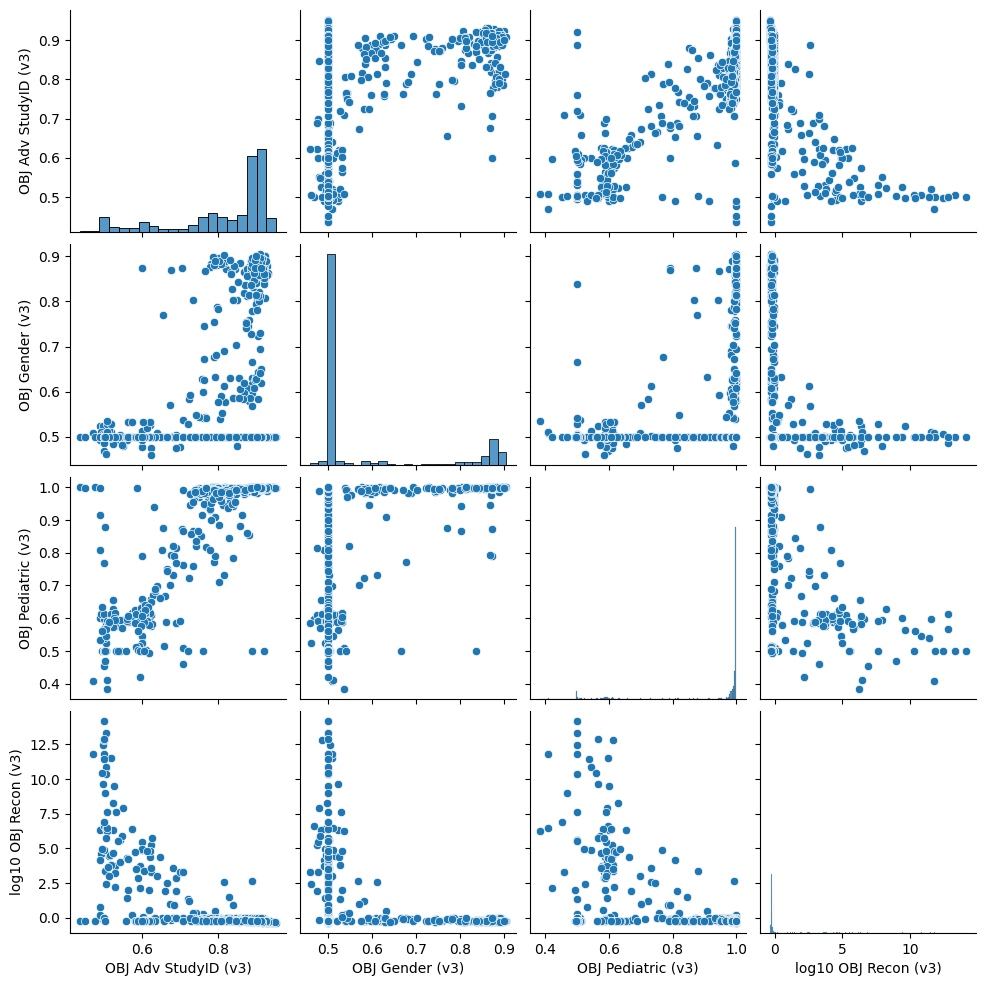

In [112]:
sns.pairplot(df)

In [113]:
df.head()

,OBJ Adv StudyID (v3),OBJ Gender (v3),OBJ Pediatric (v3),log10 OBJ Recon (v3)
sys/id,,,,
RCC-1794,0.906498,0.865653,0.999098,-0.231112
RCC-1793,0.882786,0.878945,0.998808,-0.272251
RCC-1792,0.899790,0.889079,0.999015,-0.254734
RCC-1790,0.895263,0.884665,0.998480,-0.253991
RCC-1789,0.902792,0.896469,0.999269,-0.218968


In [143]:
# remove rows with gender below 0.55

df_filtered = df[df['OBJ Gender (v3)'] > 0.6].copy()
df_filtered = df_filtered[df_filtered['log10 OBJ Recon (v3)'] < 0 ].copy()
print('df shape:', df_filtered.shape)

df shape: (200, 4)


In [139]:
sense_list = ['min','max','max','min']

df_filtered = df_filtered.round(5)
res = pareto_reduction(df_filtered, sense_list=sense_list, desired_num=1, objective_cols=objective_cols)

In [140]:
print('res shape:', res.shape)
res.head()

res shape: (71, 4)


,OBJ Adv StudyID (v3),OBJ Gender (v3),OBJ Pediatric (v3),log10 OBJ Recon (v3)
sys/id,,,,
RCC-1793,0.88279,0.87894,0.99881,-0.27225
RCC-1790,0.89526,0.88466,0.99848,-0.25399
RCC-1788,0.48905,0.52341,0.60036,6.35735
RCC-1786,0.88698,0.89239,0.99577,-0.29489
RCC-1777,0.87462,0.81104,0.99446,-0.26948


In [121]:
df['pareto_front'] = 'no'
df.loc[res.index, 'pareto_front'] = 'yes'
df.loc[top_run_ids, 'pareto_front'] = 'top'


df['size'] = 2
df.loc[res.index, 'size'] = 5
df.loc[top_run_ids, 'size'] = 10

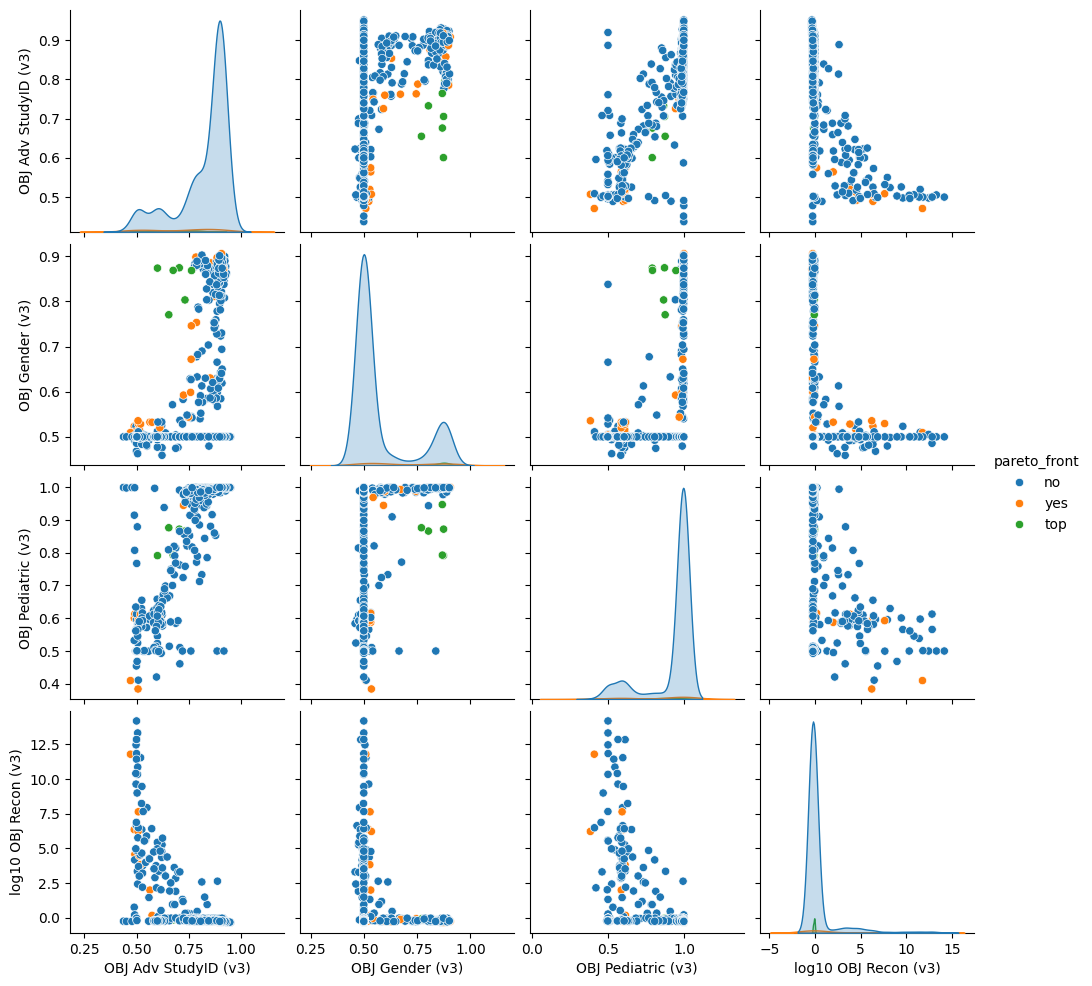

In [119]:
sns.pairplot(df, hue='pareto_front')#,plot_kws={'alpha': 0.5}


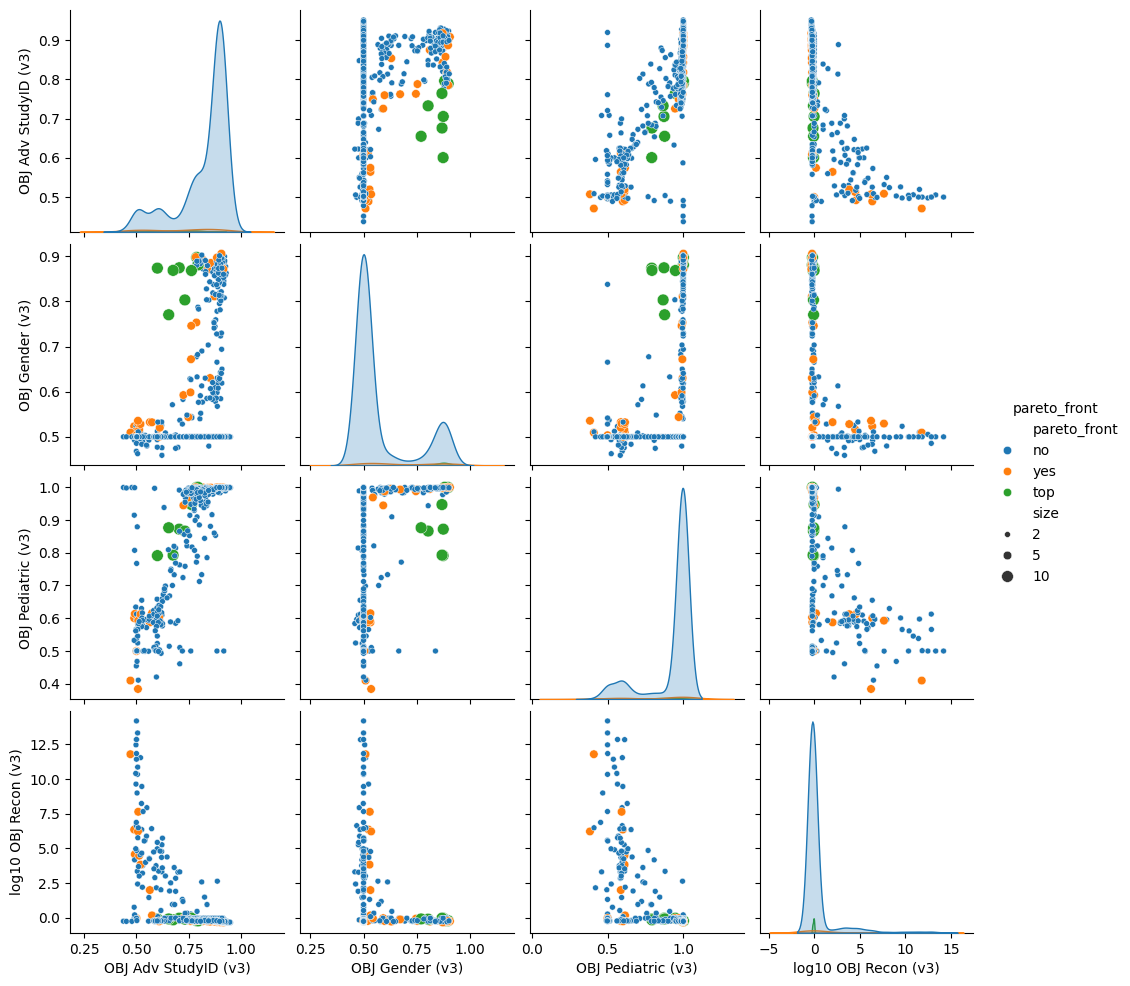

In [128]:
sns.pairplot(df[objective_cols+['pareto_front']], hue='pareto_front', plot_kws={'size': df['size']})


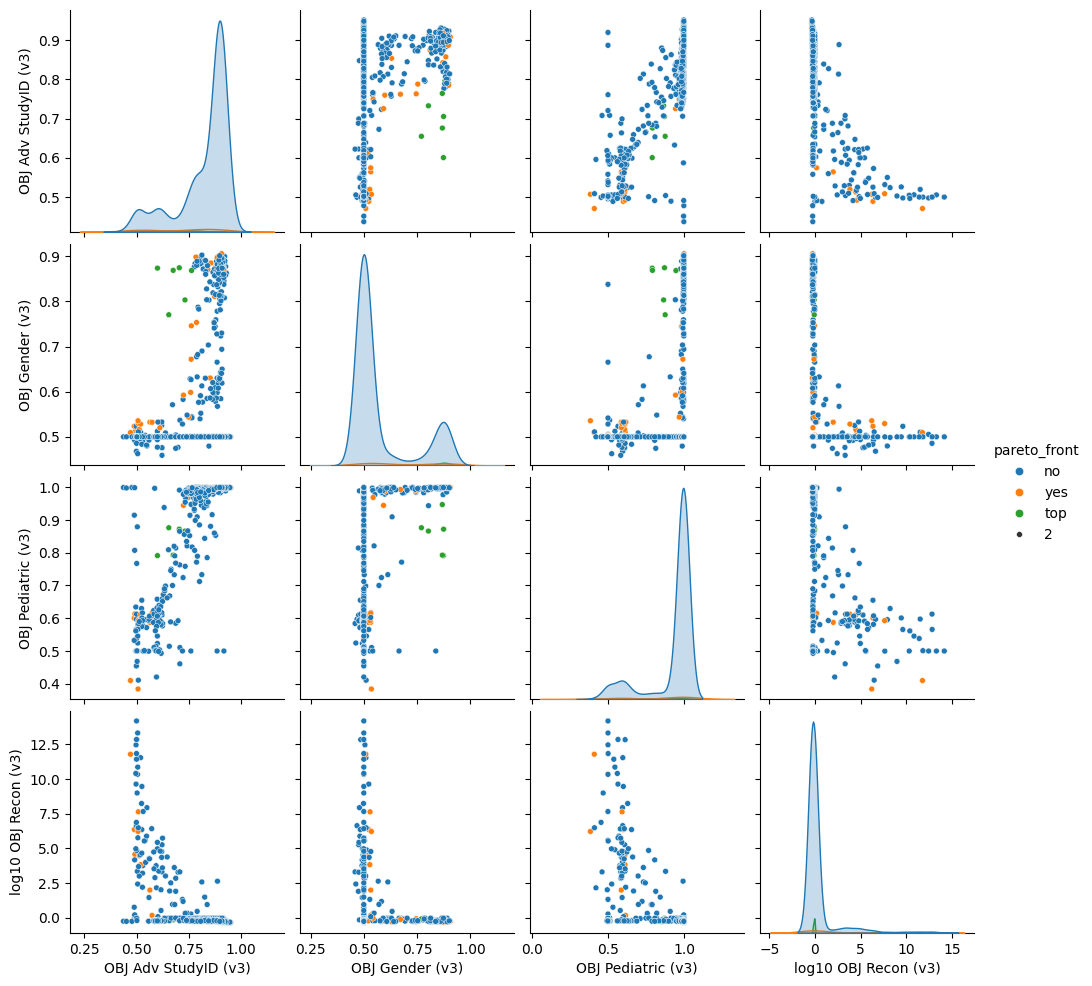

In [120]:
sns.pairplot(df, hue='pareto_front',plot_kws={'size': 2})


In [91]:
# add the tag to the top runs
chosen_runs = res.index.tolist()

for run_id in chosen_runs:
    run, _ = start_neptune_run(with_run_id=run_id)
    run['sys/tags'].add('april04_pareto')
    run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1793
Continuing run: RCC-1793
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-1793/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1788
Continuing run: RCC-1788
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app:

In [92]:
run, _ = start_neptune_run(with_run_id=run_id)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1511
Continuing run: RCC-1511


In [94]:
struc = run.get_structure()

In [96]:
struc['pretrain'].keys()

dict_keys(['Z_embed_val', 'eval', 'kwargs', 'models', 'original_kwargs', 'train'])

In [97]:
struc['pretrain']['models'].keys()

dict_keys(['Binary_isFemale_info', 'Binary_isFemale_state', 'Binary_isPediatric_info', 'Binary_isPediatric_state', 'MultiClass_Adv StudyID_info', 'MultiClass_Adv StudyID_state', 'encoder_state_dict'])

In [144]:

chosen_runs = df_filtered.index.tolist()

for run_id in chosen_runs:
    run, _ = start_neptune_run(with_run_id=run_id)
    run['sys/tags'].add('april04_top200')
    run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1794
Continuing run: RCC-1794
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-1794/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-1793
Continuing run: RCC-1793
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: